# 1	Draft Data Dictionary Land Management Schemes [Oct 2020]

## Introduction

This is a reproducible data dictionary based on a python script to scrape Natural England and Forestry Commission open data in order to perform analysis for National Parks England. As this is a script, it can be re-run as and when the data is updated. Moreover, this analysis is reproducible meaning this analysis can be copied or investigated and improved on. For further details contact;

david.alexander@peakdistrict.gov.uk

The area managed under agri-environment agreements: ie the total area under Environmental Stewardship (ES), Countryside Stewardship (CS) (including its different levels), and area under England Woodland Grant Scheme (EWGS)

### Environmental Stewardship (ES)

**ES** is an agri-environment scheme which provides funding to farmers and other land managers in England who deliver effective environmental management on their land.

It has four elements:
* Entry Level Stewardship (ELS)
* Organic Entry Level Stewardship (OELS)
* Uplands Entry Level Stewardship (Uplands ELS)
* Higher Level Stewardship (HLS).

Upland ELS can apply to any agreement with an ELS or OELS component and therefore their figures are subsumed in the ELS, ELS/HLS, OELS and OELS/HLS categories.

##### Data available;

1. **Environmental Stewardship Scheme (England) holdings agreement** polygons (includes farm business and payment info).

2. **Environmental Stewardship Scheme (England) options** points derived from Genesis tables. 

### Countryside Stewardship (CS)

**CS** is an agri-environment scheme with Higher Tier, full Mid tier, Mid Tier wildlife packages and Hedgerows and Boundaries grant schemes.

##### Data available;

3. **Countryside Stewardship Scheme 2016-2020 Management Areas** geographic extent and location of all land under management within the Countryside Stewardship Agri-Environment Scheme.

4. **Countryside Stewardship Scheme Agreements** holding boundaries data.

6. **Countryside Stewardship Scheme Agreement Option** points. 

### England Woodland Grants Scheme (EWGS)

**EWGS** is the legacy England Woodland Grant Scheme by the Forestry Commission. EWGS is now closed and was superseded by Countryside Stewardship in 2015.

##### Data available

7. **English Woodland Grant Scheme Boundary** the English Woodland Grant Scheme (EWGS) was launched in 2005 and offered 6 grants for the creation and stewardship of woodlands. This dataset contains the scheme or 'case' boundaries that make up the EWGS applications approved by the Forestry Commission. EWGS is now closed and was superseded by Countryside Stewardship in 2015.

8. **England Woodland Grant Scheme 1** WGS1 operated between June 1988 and June 1991. It was replaced by WGS2.

9. **England Woodland Grant Scheme 2** the dataset identifies areas approved by grant type. As the boundaries of the scheme were never digitised, an approximation polygon was created for each scheme. The approximation is based on the Ordnance Survey grid reference held for each scheme; this point location being buffered by a distance proportional to the total area of the scheme. WGS2 operated between June 1991 and September 1994. It was replaced by WGS3

10. **England Woodland Grant Scheme 3** there are two spatial datasets associated with the WGS. These represent the scheme boundary and the grant areas that are encapsulated by this scheme boundary.WGS3 was operative from October 1994 until its closure to new applications in June 2004.

### Further information

The PDNPA and other NPAs also have their own small scale Land Management Grant Scheme not currently in this analysis.

## Manage the GIS

In [1]:
from arcgis import GIS
from arcgis.features.manage_data import extract_data
import arcpy
import os
import pandas
import numpy as np
from matplotlib import pyplot as plt
gis = GIS("Pro")
print(gis)

GIS @ https://www.arcgis.com/ version:8.3


In [2]:
# setup the environment
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True
arcpy.env.workspace = 'C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data/'
outgdb = 'C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/Land Management Schemes.gdb'

## Data used in this analysis

Use the [ESRI living Atlas](https://livingatlas.arcgis.com/en/home/) layers as the sources of data

In [43]:
# find the data
CS_item = gis.content.get('b63046f37b5d4869b47ed16d4e23a168')
ES_item = gis.content.get('ca68c90958c342a285d6370ddd7edd66')
EWGS_item = gis.content.get('b04623c9c3d046e8a4e94666b6617df8')
EWGS_1_item = gis.content.get('d527d55fd5104e80b1bf2d80643f5865')
EWGS_2_item = gis.content.get('9752787986da4f44b4abd4bd4f494605')
EWGS_3_item = gis.content.get('3e26fc54a1d4479f90d5f268cc83a0a9')
PDNP_item = gis.content.get('73dc1cbc587f4e518a0010dceb9eab24')
NPE_item = gis.content.get('d333c7529754444894e2d7f5044d1bbf')

<Item title:"Countryside Stewardship Scheme 2016 Management Areas (England)" type:Feature Layer Collection owner:Opendata_NE>
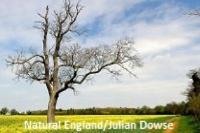

<Item title:"Environmental Stewardship Scheme Agreements (England)" type:Feature Layer Collection owner:Opendata_NE>
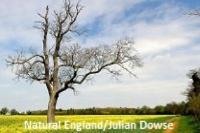

<Item title:"English Woodland Grant Scheme Boundary" type:Feature Layer Collection owner:mapping.geodata_forestry>
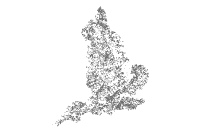

<Item title:"Woodland Grant Scheme 1 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
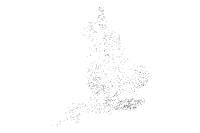

<Item title:"Woodland Grant Scheme 2 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
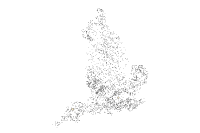

<Item title:"Woodland Grant Scheme 3 England" type:Feature Layer Collection owner:mapping.geodata_forestry>
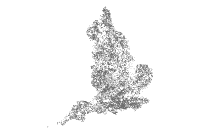

<Item title:"National Parks (England)" type:Feature Layer Collection owner:Opendata_NE>
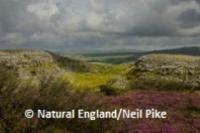

In [44]:
# display the items
data = [CS_item, ES_item, EWGS_item, EWGS_1_item, EWGS_2_item, EWGS_3_item, NPE_item]
for item in data:
    display(item)

In [26]:
# download the data
CS_gbd = extract_data([CS_item], data_format = 'Shapefile')
CS_gbd.download('C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data')
ES_gbd = extract_data([ES_item], data_format = 'Shapefile')
ES_gbd.download('C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data')
NPE_gbd = extract_data([NPE_item], data_format = 'Shapefile')
NPE_gbd.download('C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/data')

In [27]:
# add the data to the geodatabase
fcs = arcpy.ListFeatureClasses()
for fc in fcs:
    desc = arcpy.da.Describe(fc)
    outfc = os.path.join(outgdb, desc["baseName"])
    arcpy.CopyFeatures_management(fc, outfc)

## Data pre-processing

1. Re-set the WS env & Clip the data to National Parks England (NPE) boundaries
2. Call **geopandas** to create a df and use **Pandas** for data processing.
3. Create a new column **[END_YEAR]** and extract the calendar year from **[ENDDATE]** in the dataframe

4. Create a new column **[AREA_CLIP]** using the clipped **geometry** and add the calculated area (as data has been clipped some agreements overlap the boundary). This new column shows the area (sqkm) just inside the National Parks boundary.

5. **Sjoin** the NPE data to the ES and CS data so the data can be analysed collectively and individually for all NP's

In [4]:
# Switch the workspace to the geodatabse
arcpy.env.workspace = 'C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/Land Management Schemes.gdb'
# Clip the data to National Park England
arcpy.Clip_analysis("Environmental_Stewardship_Scheme_Agreements__England____Natural_England", "National_Parks__England____Natural_England", "ES_clip")
arcpy.Clip_analysis("Countryside_Stewardship_Scheme_Management_Areas__England____Natural_England", "National_Parks__England____Natural_England", "CS_clip")

In [6]:
# import pandas :)
import geopandas as gpd
import pandas as pd

In [7]:
# create a geopandas data frame for NPE
NPE_gdf = gpd.read_file("C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/Land Management Schemes.gdb/", layer = "National_Parks__England____Natural_England")

##### Environmental Stewardship;

In [11]:
# create a geopandas data frame
ES_clip_gdf = gpd.read_file("C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/Land Management Schemes.gdb/", layer = "ES_clip")
# create the [END_YEAR] column
ES_clip_gdf['END_YEAR'] = pd.DatetimeIndex(ES_clip_gdf['ENDDATE']).year
# create the [AREA] column
ES_clip_gdf['AREA_CLIP'] = ES_clip_gdf['geometry'].area/10**6
# create a spatial join and append the NPE to the left of the gpd
ES_clip_gdf = gpd.sjoin(NPE_gdf, ES_clip_gdf, how="inner", op="intersects")
# take a look at the first 2 rows of the df to check :)
ES_clip_gdf.head(2)

,FID_1_left,CODE,NAME,MEASURE,DESIG_DATE,HOTLINK,STATUS,SHAPE_Leng_left,Shape_Length_left,Shape_Area_left,geometry,index_right,FID_1_right,AGREF,CPH,CUSTNAME,TOWN,SCHEME,REGION,NCA,LAND_CTY,ELSAREA,HLSAREA,APPSTAT,LIVEDATE,STARTDAT,OPTSONAG,TILE,ENDDATE,RDA_NAME,GROSSAR,TOTCOST,AMTPAID,NUMPARCS,ARUAGR,PERMACS,EDUACS,UELSFLG,BUS_FLAG,SHAPE_Leng_right,Shape_Length_right,Shape_Area_right,END_YEAR,AREA_CLIP
0,1,10,SOUTH DOWNS,1653.0,2009-11-02T00:00:00,http://southdowns.gov.uk/,Designated,602554.506861,602554.506861,1.652679e+09,"MULTIPOLYGON (((484696.203 108041.303, 484694....",513,7739,AG00470413,150080081,JR & DL Wolfe,Alton,Entry Level plus Higher Level Stewardship,South East,HAMPSHIRE DOWNS,Hampshire,2619.04,71.84,Live,30/09/2013,01/10/2013,"A13,C,EA1,EB2,EB3,EC1,ED3,EE3,EE6,EF22,EF4,EG1...",SU,30/09/2023,"Dorset, Hampshire and the Isle of Wight Area Team",163.69,74398.37,68368.84,30.0,163.69,NULL,N,N,Y,16830.339534,16830.950910,1.636828e+06,2023,1.636828
0,1,10,SOUTH DOWNS,1653.0,2009-11-02T00:00:00,http://southdowns.gov.uk/,Designated,602554.506861,602554.506861,1.652679e+09,"MULTIPOLYGON (((484696.203 108041.303, 484694....",515,7770,AG00471670,152200094,REED FARM PARTNERSHIP,PETERSFIELD,Entry Level plus Higher Level Stewardship,South East,HAMPSHIRE DOWNS,Hampshire,2032.29,187.07,Live,29/08/2013,01/09/2013,"A13,E,EA1,EB2,EB3,EC1,EC2,EE3,EF1,EF22,EK3,FEP...",SU,31/08/2023,"Dorset, Hampshire and the Isle of Wight Area Team",156.33,92707.04,61583.83,43.0,156.33,NULL,N,N,Y,19660.611946,19660.611896,1.588621e+06,2023,1.588621


##### Countryside Stewardship; 

In [9]:
# create a geopandas data frame
CS_clip_gdf = gpd.read_file("C:/Users/alexad/Documents/ArcGIS/Projects/Land Management Schemes/Land Management Schemes.gdb/", layer = "CS_clip")
# create the [END_YEAR] column
CS_clip_gdf['END_YEAR'] = pd.DatetimeIndex(CS_clip_gdf['ENDDATE']).year
# create the [AREA] column
CS_clip_gdf['AREA_CLIP'] = CS_clip_gdf['geometry'].area/10**6
# create a spatial join and append the NPE to the left of the gpd
CS_clip_gdf = gpd.sjoin(NPE_gdf, CS_clip_gdf, how="inner", op="intersects")
# take a look at the first 2 rows of the df to check :)
CS_clip_gdf.head(2)

,FID_1_left,CODE,NAME,MEASURE,DESIG_DATE,HOTLINK,STATUS_left,SHAPE_Leng_left,Shape_Length_left,Shape_Area_left,geometry,index_right,FID_1_right,CSREF,STATUS_right,CS_TYPE,STARTDATE,ENDDATE,ORG_NAME,DURATION,TOTVAL,GROSSAR,SUM_GIS_HA,AVGANNCOST,TOTVAL_NO,APP_YEAR,MAG_CS_TYP,SHAPE_Leng_right,Shape_Length_right,Shape_Area_right,END_YEAR,AREA_CLIP
0,1,10,SOUTH DOWNS,1653.0,2009-11-02T00:00:00,http://southdowns.gov.uk/,Designated,602554.506861,602554.506861,1.652679e+09,"MULTIPOLYGON (((484696.203 108041.303, 484694....",471,14381,674733,Agreement Live,Mid Tier,01-01-2019 00:00:00,31-12-2023 00:00:00,National Trust,5,28291.95,190.65,38.135134,5658.39,28291.95,2018,COUNTRYSIDE STEWARDSHIP (Middle Tier)\n\n,2906.83452,2906.834520,3.813513e+05,2023,0.381351
0,1,10,SOUTH DOWNS,1653.0,2009-11-02T00:00:00,http://southdowns.gov.uk/,Designated,602554.506861,602554.506861,1.652679e+09,"MULTIPOLYGON (((484696.203 108041.303, 484694....",1808,14413,676435,Agreement Live,WOODLAND MANAGEMENT PLAN,01-05-2019 00:00:00,30-04-2021 00:00:00,EASTBOURNE BOROUGH COUNCIL,2,2259.1,666.33,144.273096,1129.55,2259.10,2019,WOODLAND MANAGEMENT PLAN,27086.53521,26847.071626,1.437498e+06,2021,1.437498


# Data Analysis National Parks England

Plot the data to show NPE with the cut polygons for ES & CS

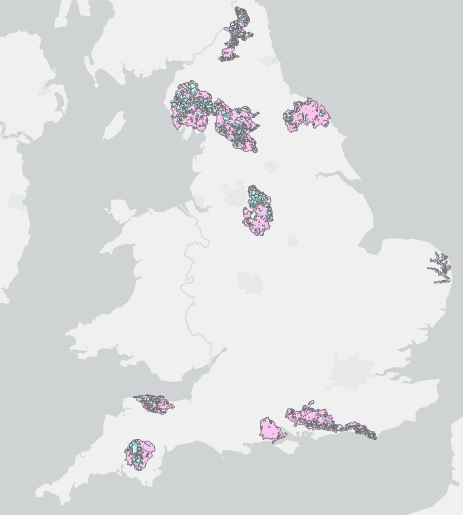

### What is the area of land in Land Management Schemes in English National Parks?

In [15]:
Total_ES_area = ES_clip_gdf['AREA_CLIP'].sum()
Total_CS_area = CS_clip_gdf['AREA_CLIP'].sum()
print ("The total area of ES in NPE is", round(Total_ES_area, 2), "sq km", "\nand the total area of ES in NPE is", round(Total_CS_area, 2), "sq km")

The total area of ES in NPE is 5010.56 sq km 
and the total area of ES in NPE is 1381.16 sq km


Lets [pivot](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html#pivot-tables) the data to provide us with some NPE summary statistics 

##### Environmental Stewardship area of live agreements sq km

In [52]:
ES_table = pd.pivot_table(ES_clip_gdf, values = 'AREA_CLIP', index = 'NAME', columns = 'APPSTAT', aggfunc=np.sum)
ES_table['NP_AREA'] = pd.pivot_table(ES_clip_gdf, values = 'MEASURE', index = 'NAME')

In [53]:
ES_table

APPSTAT,Live,NP_AREA
NAME,,
DARTMOOR,442.703682,956.0
EXMOOR,287.153333,693.0
LAKE DISTRICT,1243.147002,2362.0
NEW FOREST,48.105878,567.0
NORTH YORK MOORS,313.681742,1441.0
NORTHUMBERLAND,538.937613,1051.0
PEAK DISTRICT,644.943162,1438.0
SOUTH DOWNS,501.443350,1653.0
THE BROADS,125.050708,302.0


##### Environmental Stewardship area of live agreements by Scheme Type

In [79]:
pd.pivot_table(ES_clip_gdf, values = 'AREA_CLIP', index = ['NAME'], columns = ['SCHEME'], aggfunc=np.sum)

SCHEME,Entry Level plus Higher Level Stewardship,Higher Level Stewardship,Organic Entry Level plus Higher Level Stewardship
NAME,,,
DARTMOOR,436.911393,NaN,5.792289
EXMOOR,244.399698,5.900590,36.853046
LAKE DISTRICT,1231.369250,5.630086,6.147665
NEW FOREST,26.803990,21.301888,NaN
NORTH YORK MOORS,308.165743,0.968352,4.547647
NORTHUMBERLAND,530.423746,NaN,8.513866
PEAK DISTRICT,621.120214,20.890940,2.932008
SOUTH DOWNS,434.792088,28.804462,37.846800
THE BROADS,116.305006,8.745701,NaN


##### Countryside Stewardship area of live agreements sq km

In [54]:
CS_table = pd.pivot_table(CS_clip_gdf, values = 'AREA_CLIP', index = 'NAME', columns = 'STATUS_right', aggfunc=np.sum)
CS_table['NP_AREA'] = pd.pivot_table(CS_clip_gdf, values = 'MEASURE', index = 'NAME')
CS_table

STATUS_right,Agreement Live,NP_AREA
NAME,,
DARTMOOR,51.823651,956.0
EXMOOR,110.469828,693.0
LAKE DISTRICT,131.454669,2362.0
NEW FOREST,37.737883,567.0
NORTH YORK MOORS,115.868785,1441.0
NORTHUMBERLAND,221.158393,1051.0
PEAK DISTRICT,100.081362,1438.0
SOUTH DOWNS,308.035527,1653.0
THE BROADS,39.726563,302.0


In [75]:
pd.pivot_table(CS_clip_gdf, values = 'AREA_CLIP', index = 'NAME', columns = 'CS_TYPE', aggfunc=np.sum)

CS_TYPE,FEASIBILITY STUDY,FEASIBILITY STUDY AND HISTORIC BUILDING RESTORATION,HEDGEROWS AND BOUNDARIES,Higher Tier,IMPLEMENTATION PLAN,Mid Tier,TREE HEALTH IMPROVEMENT,TREE HEALTH RESTORATION,WOODLAND MANAGEMENT PLAN
NAME,,,,,,,,,
DARTMOOR,NaN,0.071337,NaN,20.535816,1.310283,25.337810,0.062659,0.233019,4.272727
EXMOOR,NaN,NaN,NaN,57.410349,NaN,47.746369,1.499138,NaN,3.813972
LAKE DISTRICT,NaN,3.625930,0.244279,68.632663,10.583127,36.937943,0.432911,0.055760,10.942056
NEW FOREST,NaN,NaN,NaN,23.669471,NaN,2.854697,NaN,NaN,11.213715
NORTH YORK MOORS,NaN,12.150226,NaN,41.029393,NaN,53.415621,NaN,NaN,9.273546
NORTHUMBERLAND,NaN,17.702822,NaN,115.776470,72.403734,12.471941,NaN,NaN,2.803426
PEAK DISTRICT,NaN,15.754371,0.118094,51.736664,3.078056,28.572113,NaN,NaN,0.822063
SOUTH DOWNS,NaN,NaN,NaN,169.769122,NaN,90.052139,NaN,NaN,48.214266
THE BROADS,NaN,NaN,NaN,10.249145,NaN,28.664030,NaN,NaN,0.813388


### By year, what is the area of land by which Land Management Schemes will be ending?

##### Environmental Stewardship area of live agreements ending by year

In [81]:
pd.pivot_table(ES_clip_gdf, values = 'AREA_CLIP', index = ['NAME'], columns = ['END_YEAR'], aggfunc=np.sum)

END_YEAR,2020,2021,2022,2023,2024
NAME,,,,,
DARTMOOR,41.295943,115.787356,182.404363,44.834625,58.381395
EXMOOR,73.703310,83.641537,2.405884,94.042449,33.360153
LAKE DISTRICT,244.684209,177.350482,128.386011,551.007582,141.718717
NEW FOREST,3.570214,34.183779,1.655552,8.696334,NaN
NORTH YORK MOORS,52.383429,135.816015,80.973670,43.741889,0.766739
NORTHUMBERLAND,103.383195,373.157187,30.007725,26.372114,6.017392
PEAK DISTRICT,45.166295,82.609593,85.353882,328.076074,103.737318
SOUTH DOWNS,79.732534,208.361007,134.605463,58.519907,20.224439
THE BROADS,8.960797,12.938955,63.129342,31.427402,8.594212


##### Countryside Stewardship area of live agreements ending by year

In [84]:
pd.pivot_table(CS_clip_gdf, values = 'AREA_CLIP', index = ['NAME'], columns = ['END_YEAR'], aggfunc=np.sum)

END_YEAR,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2036,2037,2038
NAME,,,,,,,,,,,,,,,,
DARTMOOR,NaN,NaN,2.236968,3.924393,4.008374,11.529428,14.612326,6.383064,1.014995,0.720562,7.393541,NaN,NaN,NaN,NaN,NaN
EXMOOR,NaN,NaN,NaN,3.858928,11.627981,11.617114,34.797260,5.873115,NaN,0.130977,6.452143,36.112310,NaN,NaN,NaN,NaN
LAKE DISTRICT,NaN,0.029591,11.051573,13.364001,13.459315,13.339027,44.138861,11.502509,NaN,0.986833,0.496417,13.017674,0.599376,1.589646,6.779191,1.100654
NEW FOREST,NaN,NaN,NaN,8.547921,6.887730,4.138691,9.417457,0.396776,NaN,2.312696,4.077303,1.959308,NaN,NaN,NaN,NaN
NORTH YORK MOORS,NaN,0.101293,0.543263,26.801073,21.808716,18.098630,19.023913,13.365472,2.905161,0.663525,0.928996,10.896812,0.731932,NaN,NaN,NaN
NORTHUMBERLAND,0.652618,NaN,37.549258,54.524206,13.091808,9.537045,6.730506,0.258716,18.549134,0.000067,19.167830,61.043615,0.053589,NaN,NaN,NaN
PEAK DISTRICT,2.830188,0.020698,0.420323,20.281873,15.332425,19.997149,12.325999,8.883742,0.544933,1.299506,9.158385,6.699424,2.286718,NaN,NaN,NaN
SOUTH DOWNS,NaN,NaN,3.010116,18.750692,62.054838,66.968399,96.415562,19.372556,1.811553,7.472636,14.865888,17.239740,0.073548,NaN,NaN,NaN
THE BROADS,NaN,NaN,NaN,1.169507,9.656246,13.864781,6.214284,3.181763,4.682497,NaN,0.784289,NaN,0.173195,NaN,NaN,NaN
